Questions prof :
 - Ground Truth gris pour premières images
 - Méthode de calcul d'erreur (gris autour détection)

In [5]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from skimage import io

ModuleNotFoundError: No module named 'torchvision'

In [2]:
# Nous utilisons cette fonction pour la reproductibilité des résultats
def set_seed():
    seed = 1952752
    random.seed(seed)
    np.random.seed(seed)
    cv2.setRNGSeed(seed)

In [3]:
def read_image(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

In [4]:
input_file_names = os.listdir('./data/highway/input/')
gt_file_names = os.listdir('./data/highway/groundtruth/')

input_images = [ read_image('./data/highway/input/'+str(path)) for path in input_file_names]
gt_images = [ read_image('./data/highway/groundtruth/'+str(path)) for path in gt_file_names]

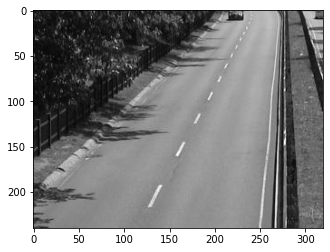

In [5]:
plt.figure()
plt.imshow(input_images[500], cmap=plt.get_cmap('gray'))
plt.show()

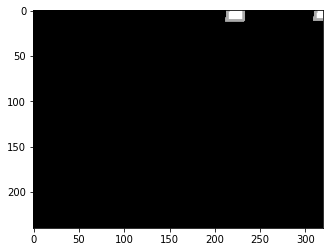

In [6]:
plt.figure()
plt.imshow(gt_images[500], plt.get_cmap('gray'))
plt.show()

# Substraction d'arrière-plan

In [ ]:
## Code from : https://github.com/yangshiyu89/VIBE 
def initial_background(I_gray, N):
    
    I_pad = np.pad(I_gray, 1, 'symmetric')
    height = I_pad.shape[0]
    width = I_pad.shape[1]
    samples = np.zeros((height,width,N))
    for i in tqdm(range(1, height - 1)):
        for j in range(1, width - 1):
            for n in range(N):
                x, y = 0, 0
                while(x == 0 and y == 0):
                    x = np.random.randint(-1, 1)
                    y = np.random.randint(-1, 1)
                ri = i + x
                rj = j + y
                samples[i, j, n] = I_pad[ri, rj]
    samples = samples[1:height-1, 1:width-1]
    return samples
    
def vibe_detection_and_update(I_gray, samples, _min, N, R):

    height = I_gray.shape[0]
    width = I_gray.shape[1]
    segMap = np.zeros((height, width)).astype(np.uint8)
    for i in range(height):
        for j in range(width):
            count, index, dist = 0, 0, 0
            while count < _min and index < N:
                dist = np.abs(I_gray[i,j] - samples[i,j,index])
                if dist < R:
                    count += 1
                index += 1
            if count >= _min:
                r = np.random.randint(0, N-1)
                if r == 0:
                    r = np.random.randint(0, N-1)
                    samples[i,j,r] = I_gray[i,j]
                r = np.random.randint(0, N-1)
                if r == 0:
                    x, y = 0, 0
                    while(x == 0 and y == 0):
                        x = np.random.randint(-1, 1)
                        y = np.random.randint(-1, 1)
                    r = np.random.randint(0, N-1)
                    ri = i + x
                    rj = j + y
                    try:
                        samples[ri, rj, r] = I_gray[i, j]
                    except:
                        pass
            else:
                segMap[i, j] = 255
    return segMap, samples

In [ ]:
N = 20
R = 20
MIN = 2

def ViBE(input_images, N=N, R=R, MIN=MIN):
    print("Creating initial background ...")
    samples = initial_background(input_images[0], N)

    predictions = []
    print("Making predictions ...")
    for input_image in tqdm(input_images) : 
        segMap, samples = vibe_detection_and_update(input_image, samples, MIN, N, R)
        predictions.append(segMap)
    return predictions

In [ ]:
GRAY_OUTLINE = 170
NO_PRED = 85

def segmentation_accuracy_recall_precision(truth, pred):
    total_size = truth.shape[0] * truth.shape[1]
    
    truth[truth == GRAY_OUTLINE] = pred[truth == GRAY_OUTLINE]
    correct_T_or_F = np.sum(truth == pred)
    accuracy = correct_T_or_F/total_size
    
    tp = np.sum(truth[truth==255] == pred[truth==255])
    recall = tp/np.sum(truth==255)
    precision = tp/np.sum(pred==255)
    
    f1 = 2*precision*recall/(precision+recall)
    
    return accuracy, recall, precision, f1

def get_metrics(gt_images, predictions):
    accuracy = []
    recall = []
    precision = []
    f1_score = []
    
    for i in tqdm(range(len(predictions))):
        if gt_images[i][0,0] == NO_PRED:
            continue
        acc, re, pre, f1 = segmentation_accuracy_recall_precision(gt_images[i], predictions[i])
        accuracy.append(acc)
        recall.append(re)
        precision.append(pre)
        f1_score.append(f1)
    
    return accuracy, recall, precision, f1_score

In [ ]:
def execute_vibe_on(video_name, save_results=True):
    input_folder = './data/'+str(video_name)+'/input/'
    gt_folder = './data/'+str(video_name)+'/groundtruth/'

    input_file_names = os.listdir('./data/highway/input/')
    gt_file_names = os.listdir('./data/highway/groundtruth/')

    print('Loading input images...')
    input_images = [ read_image('./data/highway/input/'+str(path)) for path in tqdm(input_file_names)]
    
    print('Loading groundtruth images ...')
    gt_images = [ read_image('./data/highway/groundtruth/'+str(path)) for path in tqdm(gt_file_names)]
    
    predictions = ViBE(input_images)
    
    if(save_results):
        for index, pred in tqdm(enumerate(predictions)):
            file_path = './data/'+str(video_name)+'/predictions/r' + str(index+1).rjust(6, '0') +'.jpg'
            cv2.imwrite(file_path, pred)
    
    return get_metrics(gt_images, predictions), predictions

In [ ]:
metrics, predictions = execute_vibe_on("highway")

In [ ]:
print("Average accuracy : " + str(np.mean(metrics[0])))
print("Average recall : " + str(np.mean(metrics[1])))
print("Average precision : " + str(np.mean(metrics[2])))
print("Average f1 score : " + str(np.mean(metrics[3])))

In [ ]:
print("Accuracy")
plt.plot(metrics[0])

In [ ]:
print("Recall")
plt.plot(metrics[1])

In [ ]:
print("Precision")
plt.plot(metrics[2])

In [ ]:
print("F1 Score")
plt.plot(metrics[3])

# Segmentation Sémantique

In [ ]:
# Load images
input_file_names = os.listdir('./data/highway/input/')
gt_file_names = os.listdir('./data/highway/groundtruth/')

input_images = [ read_image('./data/highway/input/'+str(path)) for path in input_file_names]
gt_images = [ read_image('./data/highway/groundtruth/'+str(path)) for path in gt_file_names]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((512,512), interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def read_and_normalize_images(path):
    img = Image.fromarray(io.imread(path))